# Customer Segmentation

# Import  Libraries


In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm


In [2]:
data = pd.read_csv("C:\\Users\\Dell\\Downloads\\data.csv",encoding='latin1')

In [3]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Pre-Processing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
%%time
#make date format consistent 
data['InvoiceDate']=pd.to_datetime((data['InvoiceDate']))

CPU times: total: 3.48 s
Wall time: 3.48 s


In [7]:
#make country a categorical variable
data["Country"] = data["Country"].astype('category')

# Missing Values

In [8]:


## This function counts and creates a dataframe containing the nuber of missing values per column.

# Declare the name of the fuction 
def count_missing(data):
    # creates a dataframe containing the sum of all missing values
    missing_count = pd.DataFrame(data.isnull().sum(),\
                                 # names column "Count" and sorts values in descending order
                                 columns=['Count']).sort_values(by=['Count'],\
                                                                ascending=False)
    return missing_count

#apply the function to the data 
count_missing(data)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


# Dealing With Missing Values

In [9]:


# replace missing descriptions with "Missing"
data["Description"] = data["Description"].fillna("Missing")


In [10]:
#delete all rows with a missing "CustomerID"
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

#check that there aren't any missing values
count_missing(data)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


# Create New Variables

In [11]:
%%time
#create a function that will assign 0 to all variables unless the first character of 'InvoiceNo' in 'C'
def cancel(row):
    value = 0
    if row['InvoiceNo'][0] == 'C':
        value = 1
    return value

# Create a new column 'Cancel' to attach to 'data' and set it to the value returned 
  #by the function cancel().
    
# The code 'axis=1' makes the apply function process the dataset by row, 
  #as opposed to by column which is the default option.
data['Cancel'] = data.apply(cancel, axis=1)


CPU times: total: 7.5 s
Wall time: 7.57 s


In [12]:
#check that there are some cancelled orders and that the new column is in the data
data[data['Cancel']== 1].head(3)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1


In [13]:
#check how many cancelled VS non-cancelled orders there are. 
canceled = data['Cancel'].value_counts()

# rename the axis so that they show in the picture
canceled = canceled.rename({0: 'Non-canceled', 1: 'Canceled'})

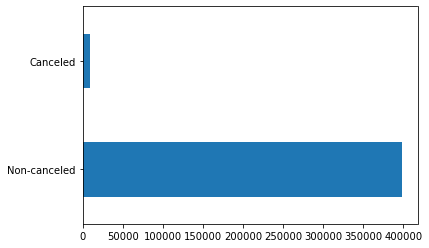

In [14]:
# bar graph of canceled vs non-canceled orders 
canceled.plot.barh();

In [15]:
#calculate the probability of an order to be cancelled.
pco = (8905/(397924+8905))
pco

0.021888803403887137

In [16]:
##Transaction Spending
data['Tra_Spending']= (data['Quantity'])*(data['UnitPrice'])
data.head(3)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Tra_Spending
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00


# Grouping data by "CustomerID"
##Sum "Quantity" , "Tra_Spending" and "Cancel"¶

In [17]:
#group dataset by cystomerID to start creating customer profiles. 
#The following code groups the data by customerID and sum quantity, transaction spending, and number of cancelled orders
aggQ=data.groupby('CustomerID')['Quantity','Tra_Spending', 'Cancel'].sum()

aggQ.head(3)

,Quantity,Tra_Spending,Cancel
CustomerID,,,
12346.0,0,0.00,1
12347.0,2458,4310.00,0
12348.0,2341,1797.24,0


# Count "InvoiveNo"

In [18]:

#group by custmer and count unique invoiceNo to see how many oder the customer has placed in the time the data spans.
Inv = data.groupby('CustomerID')['InvoiceNo'].count()
Inv.head(3)

CustomerID
12346.0      2
12347.0    182
12348.0     31
Name: InvoiceNo, dtype: int64

# Create "days_as_customer"

In [19]:

#### Create a varible that shows how much time a person has been a customer.

#group by customerID and select the mininum date (i.e. the date at which the first order was placed)
#as_index=false means that customer ID is a column and not the index
days= data.groupby('CustomerID', as_index=False)['InvoiceDate'].min()

#edit names of columns 
days.columns = ['CustomerID', 'Earliest_Invoice']

#create a column with the date of the latest order placed
days['Latest_Invoice'] = pd.to_datetime((data['InvoiceDate']).max())
days.set_index('CustomerID')
days.head(3)

,CustomerID,Earliest_Invoice,Latest_Invoice
0,12346.0,2011-01-18 10:01:00,2011-12-09 12:50:00
1,12347.0,2010-12-07 14:57:00,2011-12-09 12:50:00
2,12348.0,2010-12-16 19:09:00,2011-12-09 12:50:00


In [20]:
#calculate how many days the person has been a customer by subtracting the date of the latest invoice
# to the date of the first invoice
days['days_as_customer'] = 1 + (days.Latest_Invoice-days.Earliest_Invoice).astype('timedelta64[D]')

#delete earliest invoice and laterst invoice columns
days.drop(['Earliest_Invoice', 'Latest_Invoice'], axis=1, inplace=True)
days.head()


,CustomerID,days_as_customer
0,12346.0,326.0
1,12347.0,367.0
2,12348.0,358.0
3,12349.0,19.0
4,12350.0,310.0


In [21]:
##Add "Country" of customer
#grouped data by customerID and pasted the value of 'Country' 
country = data.groupby('CustomerID')['Country'].first()
country.head(3)

CustomerID
12346.0    United Kingdom
12347.0           Iceland
12348.0           Finland
Name: Country, dtype: category
Categories (38, object): ['Australia', 'Austria', 'Bahrain', 'Belgium', ..., 'USA', 'United Arab Emirates', 'United Kingdom', 'Unspecified']

In [22]:
###Average "UnitPrice"
#group by 'customerID' and average unitprice to see if the person buys expensive items or not
meanex = data.groupby('CustomerID')['UnitPrice'].mean()
meanex.head(3)

CustomerID
12346.0    1.040000
12347.0    2.644011
12348.0    5.764839
Name: UnitPrice, dtype: float64

In [23]:
###Join data together to create new dataset
# create list of datafames to join that have the same index
to_join=[Inv, country, meanex]
# use join() to join aggQ with the three dataframes listed above
joined = aggQ.join(to_join)

joined = joined.join(days.set_index('CustomerID'))

# edit column names
joined.columns = ['total_quantity', 'total_spending',\
                    'total_cancelled_orders', 'total_orders_placed',\
                    'country_of_origin', 'average_price_of_items', 'days_as_customer']

In [24]:
#delete all negative values
joined = joined.drop(joined[(joined.total_quantity < 0)].index)
joined = joined.drop(joined[(joined.total_spending < 0)].index)

In [25]:
# look at first rows of data set
joined.head()

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,country_of_origin,average_price_of_items,days_as_customer
CustomerID,,,,,,,
12346.0,0,0.00,1,2,United Kingdom,1.040000,326.0
12347.0,2458,4310.00,0,182,Iceland,2.644011,367.0
12348.0,2341,1797.24,0,31,Finland,5.764839,358.0
12349.0,631,1757.55,0,73,Italy,8.289041,19.0
12350.0,197,334.40,0,17,Norway,3.841176,310.0


# Data Visualization

In [26]:
# look at the shape of the dataset joined. 
# this gives us the number of customers in the dataset because its rows represent a customer. 
joined.shape

(4329, 7)

<AxesSubplot:>

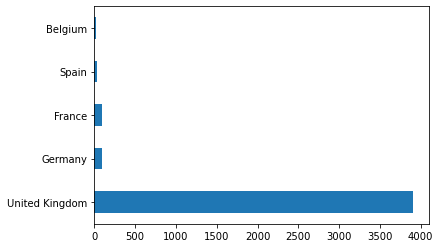

In [27]:
# return the top 5 countries from which customers are from by 
# counting the frequency of each country of origin and plotting a horizontal bar graph 
joined['country_of_origin'].value_counts()[:5].plot(kind='barh')

In [28]:
#check how many unique order numbers are in the original dataset "data" 
data['InvoiceNo'].unique().shape


(22190,)

In [29]:
#check from how many countries orders are placed from 

# select country column unique values and return the shape of the table. 
joined['country_of_origin'].unique().shape

(37,)

<AxesSubplot:>

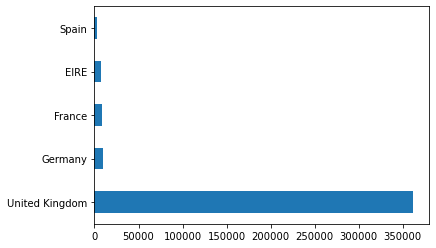

In [30]:
#code returns the first 5 coutries from which orders are placed from. 
data['Country'].value_counts()[:5].plot(kind='barh')

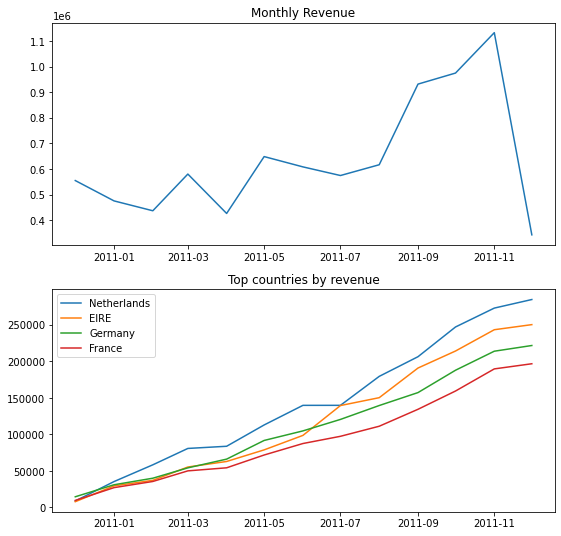

CPU times: total: 1.23 s
Wall time: 1.25 s


In [31]:
%%time
# make a copy of the dataset
data_1 = data

# split date variable in "year", "month", "day", "hour", "minute", "week" to make it easier to plot
data_1['Date'] = data['InvoiceDate'].dt.date
data_1['Day'] = data['InvoiceDate'].dt.day
data_1['Month'] = data['InvoiceDate'].dt.month
data_1['Year'] = data['InvoiceDate'].dt.year
data_1['Hour'] = data['InvoiceDate'].dt.hour
data_1['Week'] = data['InvoiceDate'].dt.week
data_1['Minute'] = data['InvoiceDate'].dt.minute

#set up graph 
fig, ax = plt.subplots(2,1, figsize=(9, 9))

### create a dataframe "sales" which is grouped by date and shows the sum of all transaction spending in one month.

## subset data_1 to include year, month and transaction spending. 
## group the subset by year and month and sum transaction spending. 
sales = data_1[['Year', 'Month', 'Tra_Spending']].groupby(['Year', 'Month']).sum().reset_index()

#create a variable called 'Date' which contains year, month and day
#set day to be one to stand for the start of the month. 
sales['Day'] = 1
#convert 'Date' to pd datetime object
sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])

#set it as the index of the dataframe
sales = sales.set_index('Date')
#delete year, month and day columns
sales = sales.drop(['Day', 'Month', 'Year'], axis=1)

#create a plot of sales. 
ax[0].plot(sales)
#set the title to 'Monthly revenue'
ax[0].set_title('Monthly Revenue') 
### Create a dataframe "top_country"
##  subset data_1 to contain transaction spending and country
#   group by country and sum the transaction spending 
top_country = data_1[['Tra_Spending', 'Country']]\
                .groupby(['Country']).sum().reset_index().sort_values\
                (by='Tra_Spending', ascending=False)['Country'][1:5]

#crate a loop that itarates for each country in the dataframe top_country
for c in top_country:
    sales = data_1[data_1['Country'] == c]
    #subgroup sales and group by year and month. 
    sales = sales[['Year', 'Month', 'Tra_Spending']].groupby(['Year', 'Month']).sum().reset_index()
    #set day to 1 
    sales['Day'] = 1
    #create date with day, month and year
    sales['Date'] = pd.to_datetime(sales[['Day', 'Month', 'Year']])
    #set index of sales to be 'Date'
    sales = sales.set_index('Date')
    #delete columns year, month, and day
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    #plot
    ax[1].plot(sales.cumsum(), label=c)    
    #this line adds a legend to the graph
    ax[1].legend()
    #this line sets the title of the graph
    ax[1].set_title('Top countries by revenue')            
    
plt.show()


# Analysis

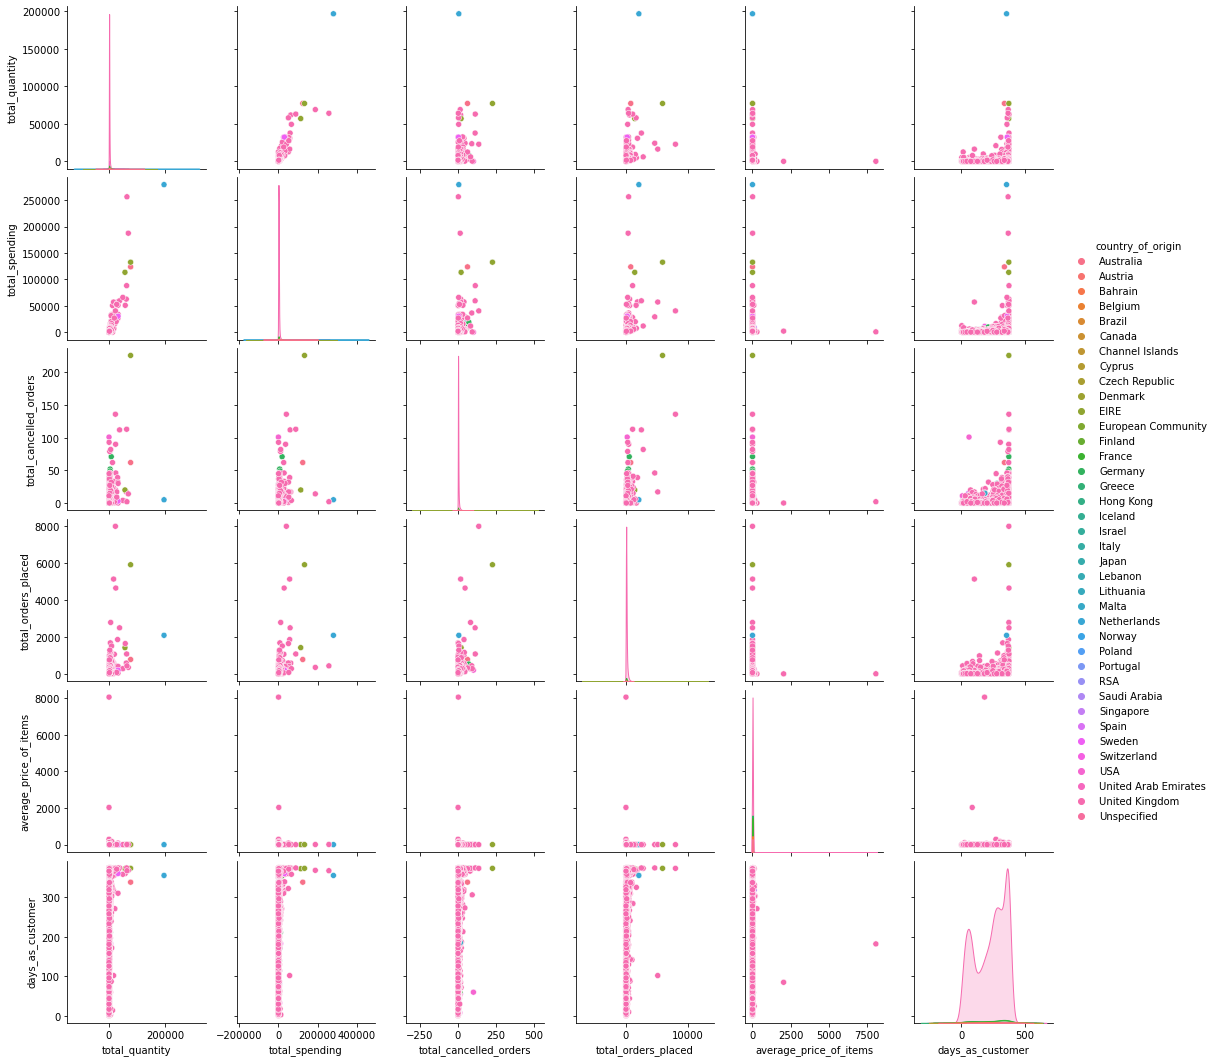

In [32]:
#pairplot gives you a scattered plot of all pairs of variables. 
# hue = country of origin colors each observation differently depending 
  # on their country of origin 
sns.pairplot(joined, kind='scatter', hue= 'country_of_origin');

In [33]:
# scale dataset

#select numerical variables to scale
num_cols= ['total_quantity', 'total_spending',\
           'total_cancelled_orders', 'total_orders_placed',\
           'average_price_of_items', 'days_as_customer']

#subset dataset to contain only numerical variables
joined_toscale = joined[num_cols]

#scale dataset
joined_scaled = pd.DataFrame(preprocessing.scale(joined_toscale),
                           index=joined_toscale.index,
                           columns=joined_toscale.columns)

#add country of origin variable for coloring of pairplot
joined_scaled["country_of_origin"]= joined["country_of_origin"]
joined_scaled.head()

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer,country_of_origin
CustomerID,,,,,,,
12346.0,-0.241563,-0.232608,-0.138582,-0.393792,-0.039814,0.852678,United Kingdom
12347.0,0.282089,0.289446,-0.274465,0.377315,-0.027125,1.199065,Iceland
12348.0,0.257164,-0.014915,-0.274465,-0.269558,-0.002436,1.123029,Finland
12349.0,-0.107135,-0.019722,-0.274465,-0.089633,0.017533,-1.740995,Italy
12350.0,-0.199594,-0.192103,-0.274465,-0.329533,-0.017654,0.717503,Norway


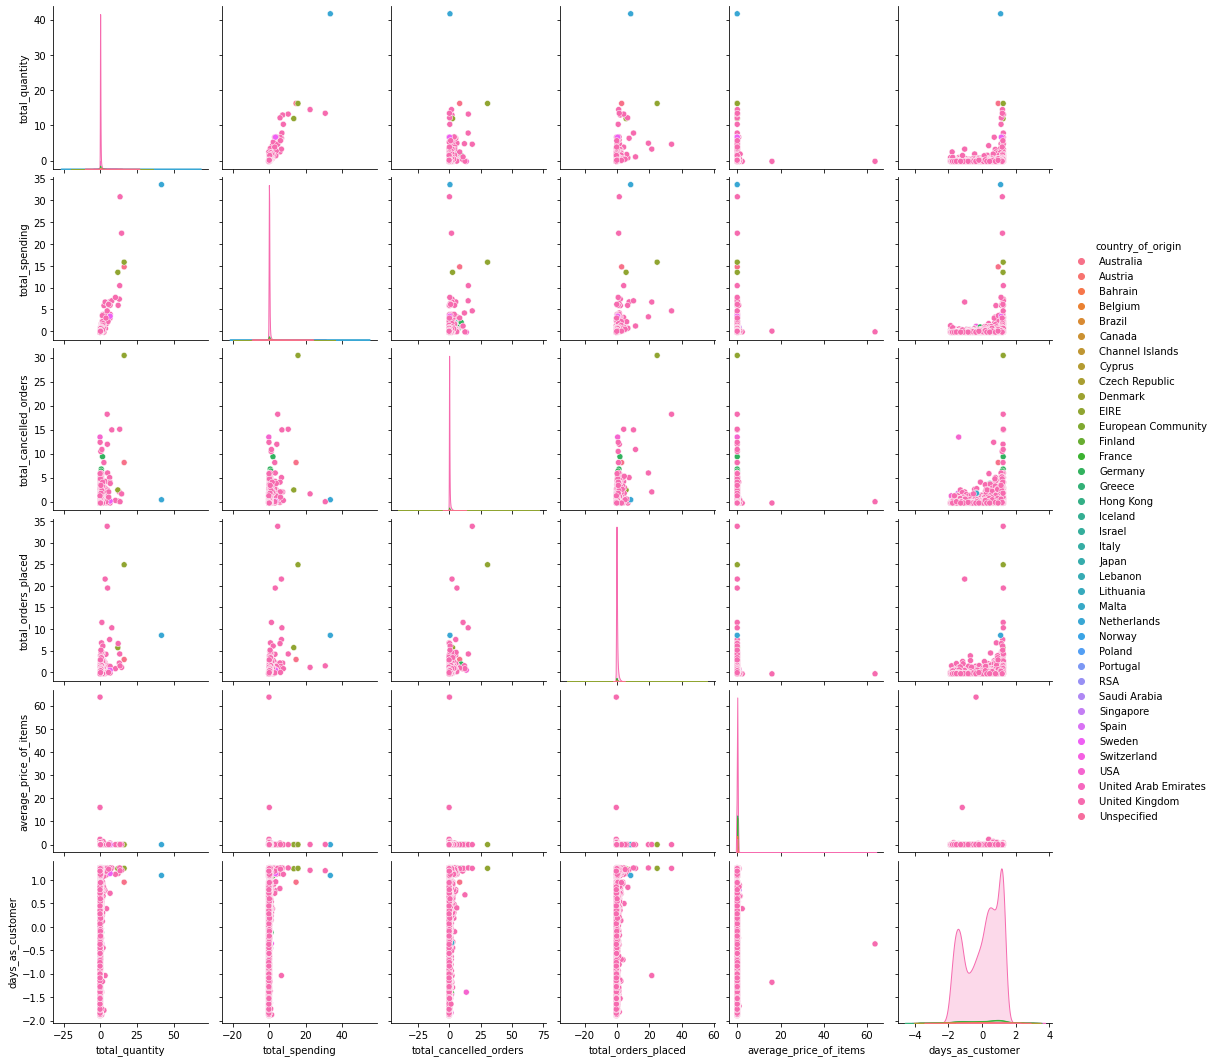

In [34]:
# new pairplot
sns.pairplot(joined_scaled, kind='scatter', hue= 'country_of_origin');

# K-means Clustering Analysis

In [35]:
# create cluster data with that contains numeric value
cluster_data_scaled = joined_scaled.loc[:, joined_scaled.columns != 'country_of_origin']
cluster_data_scaled.head(3)


,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer
CustomerID,,,,,,
12346.0,-0.241563,-0.232608,-0.138582,-0.393792,-0.039814,0.852678
12347.0,0.282089,0.289446,-0.274465,0.377315,-0.027125,1.199065
12348.0,0.257164,-0.014915,-0.274465,-0.269558,-0.002436,1.123029


In [36]:
# check the mean and standard deviation of all variables. 
cluster_data_scaled.describe().loc[['mean', 'std'], :]

#now all variables have the same standard deviation. 

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,average_price_of_items,days_as_customer
mean,1.679825e-18,-2.704790e-17,-1.004663e-15,2.862755e-17,1.695693e-17,4.252777e-17
std,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00


# Determine the Value of K - The Elbow Method

Text(0.5, 1.0, 'Elbow curve')

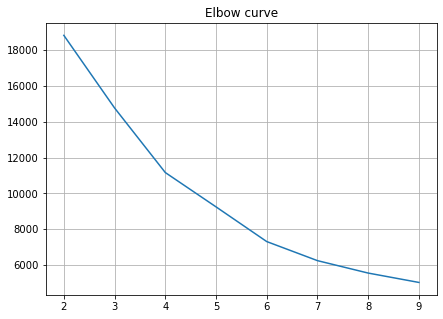

In [37]:
# ELBOW METHOD # 

# Data to run in the loop 
X = cluster_data_scaled
# create empty list to store SSEs for different k means clustering
SSE = []

# for loop runs on range between 2 and 10
for k in range(2, 10):
    # set up k means for each k between 2 and 10 
    kmeans = cluster.KMeans(n_clusters=k)
    # fit k means in data
    kmeans.fit(X)
    # append SSE values into empty list 
    SSE.append(kmeans.inertia_)

# set up elbow graph 
fig = plt.figure(figsize=(7, 5))
# plot values
plt.plot(range(2, 10), SSE)
# add grid
plt.grid(True)
# add title
plt.title('Elbow curve')


In [38]:
###Perform K-means clustering
# set up clustering analysis with k=6
k6 = cluster.KMeans(n_clusters=6)
k6

KMeans(n_clusters=6)

In [39]:
# fit clustering model on dataset created for clustering
np.random.seed(1234)
k6cl = k6.fit(cluster_data_scaled)

In [40]:
#check labels
labels=k6cl.labels_

labels

array([0, 0, 0, ..., 2, 0, 0])

In [41]:
# count how many observations each cluster has. 
labels_tb = pd.DataFrame(joined.groupby(k6cl.labels_).size())

#rename column
labels_tb.rename(columns={0:'No Customers per Cluster'}, inplace=True)

labels_tb

,No Customers per Cluster
0,2542
1,5
2,1638
3,1
4,136
5,7


In [42]:
#create table with mean values per cluster
table_of_means=joined.groupby(k6cl.labels_).mean()
#add average spend per order by dividind average total spending by average n of orders placed
table_of_means['average_spend_order']=\
                    table_of_means['total_spending']/table_of_means['total_orders_placed']

In [43]:
# look at mean of the clusters 

# .T transpose the table to make it easier to look at
table_of_means.T

,0,1,2,3,4,5
total_quantity,933.175846,92827.4000,427.657509,60.00,8268.088235,35328.571429
total_spending,1579.628329,192103.8540,661.412724,649.50,13492.293750,59766.425714
total_cancelled_orders,1.542486,20.6000,0.553114,2.00,22.647059,104.571429
total_orders_placed,92.622738,1013.4000,44.904762,5.00,459.669118,4286.428571
average_price_of_items,3.954265,6.3574,4.623050,8055.78,4.044998,3.841534
days_as_customer,304.750197,360.0000,90.848596,182.00,342.132353,334.714286
average_spend_order,17.054434,189.5637,14.729234,129.90,29.352187,13.943175


In [44]:
# recall data for regression 
joined.head()

,total_quantity,total_spending,total_cancelled_orders,total_orders_placed,country_of_origin,average_price_of_items,days_as_customer
CustomerID,,,,,,,
12346.0,0,0.00,1,2,United Kingdom,1.040000,326.0
12347.0,2458,4310.00,0,182,Iceland,2.644011,367.0
12348.0,2341,1797.24,0,31,Finland,5.764839,358.0
12349.0,631,1757.55,0,73,Italy,8.289041,19.0
12350.0,197,334.40,0,17,Norway,3.841176,310.0


In [45]:
#regression model 
m1_baseline = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + total_quantity',\
            joined).fit()

m1_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.432
Model:                             OLS   Adj. R-squared:                  0.432
Method:                  Least Squares   F-statistic:                     1096.
Date:                 Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                         11:49:10   Log-Likelihood:                -28524.
No. Observations:                 4329   AIC:                         5.706e+04
Df Residuals:                     4325   BIC:                         5.708e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 46.7414      2.804     16.671      0.000      41.244      52.238
total_cancelled_orders    16.1792      0.396     40.848      0.000      15.403      16.956
average_price_of_items    -0.0142      0.021     -0.669      0.504      -0.056       0.027
total_quantity             0.0129      0.001     20.717      0.000       0.012       0.014
==============================================================================
Omnibus:                     7907.015   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24253997.001
Skew:                          12.988   Prob(JB):                         0.00
Kurtosis:                     368.773   Cond. No.                     5.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model Explaination
 ###Scaled Baseline Model

In [46]:
# Scale the predicting variables because they are on different scales
# (the first one is in orders, and the second one is in pounds.)

# create a list that includes the columns to scale
cols = ['total_cancelled_orders', 'average_price_of_items', 'total_quantity']

#scale columns by subtracting mean and dividing by standard deviation
scaled_for_reg = pd.DataFrame(scale(joined[cols]),
                   index=joined.index,
                   columns=cols)

#add column with variable to predict 
scaled_for_reg['total_orders_placed'] = joined['total_orders_placed']

#this is the second model with the scaled columns.
m2_scaled = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + total_quantity',\
            scaled_for_reg).fit()

m2_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.432
Model:                             OLS   Adj. R-squared:                  0.432
Method:                  Least Squares   F-statistic:                     1096.
Date:                 Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                         11:49:10   Log-Likelihood:                -28524.
No. Observations:                 4329   AIC:                         5.706e+04
Df Residuals:                     4325   BIC:                         5.708e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 93.9231      2.675     35.110      0.000      88.679      99.168
total_cancelled_orders   119.0675      2.915     40.848      0.000     113.353     124.782
average_price_of_items    -1.7889      2.675     -0.669      0.504      -7.034       3.456
total_quantity            60.3891      2.915     20.717      0.000      54.674      66.104
==============================================================================
Omnibus:                     7907.015   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24253997.001
Skew:                          12.988   Prob(JB):                         0.00
Kurtosis:                     368.773   Cond. No.                         1.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Distribution of Actual Values


<AxesSubplot:xlabel='total_orders_placed', ylabel='Density'>

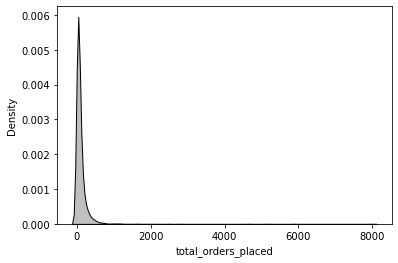

In [47]:
#Distribution of actual number of oders
sns.kdeplot(joined['total_orders_placed'], shade=True, color = 'black')

# Distribution of Baseline Model Fitted Values


<AxesSubplot:ylabel='Density'>

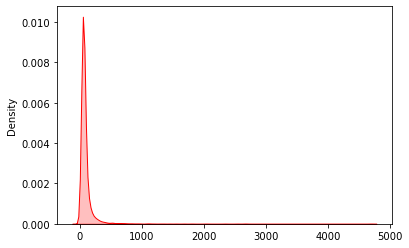

In [48]:
#distribution of predicted numbers of orders
sns.kdeplot(m1_baseline.fittedvalues, shade=True, color='red')

# Distribution of Scaled Model Fitted Values


<AxesSubplot:ylabel='Density'>

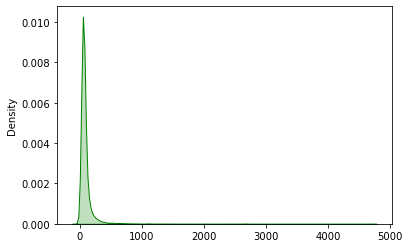

In [49]:
#distribution of predicted numbers of orders second prediction 
sns.kdeplot(m2_scaled.fittedvalues, shade=True, color='green')

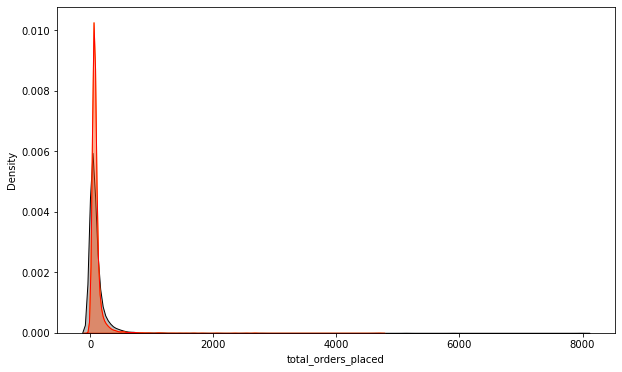

In [50]:
#make put all in the same graph
f, ax = plt.subplots(1, figsize=(10, 6))
sns.kdeplot(joined['total_orders_placed'], shade=True, ax=ax, label='actual', color= 'black')
sns.kdeplot(m2_scaled.fittedvalues, shade=True, ax=ax, label='scaled', color = 'orange')
sns.kdeplot(m1_baseline.fittedvalues, shade=True, ax=ax, label='baseline', color = 'red')
plt.show()

# Adding a Categorial Variable

In [51]:
# add "country_of_origin" variable to scaled dataset
scaled_for_reg['country_of_origin'] = joined['country_of_origin']


In [52]:
#create lists of continents. 
north_europe=['Iceland','Norway','Denmark','Sweden','Finland','Lithuania',\
             'EIRE','Channel Islands','United Kingdom']
east_europe=['Poland','Czech Republic']
south_europe=['Greece','Italy', 'Malta','Spain','Portugal',]
west_europe=['Switzerland', 'Austria','Belgium', 'Netherlands']
asia=['Cyprus','Bahrain','Israel','Saudi Arabia','United Arab Emirates','Singapore',\
      'Japan','Lebanon']
australia=['Australia']
africa=['RSA']
america=['USA','Brazil','Canada']

In [53]:
# Code country of origin by continent 

# Create a function that will assign "unspecified"to all variables unless
# The content of the row is in the list declared above. 

# Declare function
def continent(row):
    #assing all rows to unspecified 
    value = "unspecified"
    # but, if country is contained in the list north_europe, 
    if row['country_of_origin'] in north_europe:
        # give value europe and so on... 
        value = 'north europe'
    if row['country_of_origin'] in south_europe: 
        value = 'south europe'
    if row['country_of_origin'] in east_europe:
        value = 'east europe'
    if row['country_of_origin'] in west_europe:
        value = 'west europe'
    if row['country_of_origin'] in asia:
        value ='asia'
    if row['country_of_origin'] in australia:
        value='australia'
    if row['country_of_origin'] in africa:
        value = 'africa'
    if row['country_of_origin'] in america:
        value= 'america'
    #at the end, return value
    return value

# Create a new column 'continent_of_origin' and apply the function. 
scaled_for_reg['continent_of_origin'] = scaled_for_reg.apply(continent, axis=1)

In [54]:
scaled_for_reg.head()

,total_cancelled_orders,average_price_of_items,total_quantity,total_orders_placed,country_of_origin,continent_of_origin
CustomerID,,,,,,
12346.0,-0.138582,-0.039814,-0.241563,2,United Kingdom,north europe
12347.0,-0.274465,-0.027125,0.282089,182,Iceland,north europe
12348.0,-0.274465,-0.002436,0.257164,31,Finland,north europe
12349.0,-0.274465,0.017533,-0.107135,73,Italy,south europe
12350.0,-0.274465,-0.017654,-0.199594,17,Norway,north europe


In [55]:
# create new model
m3_improved = sm.ols('total_orders_placed ~ total_cancelled_orders\
            + average_price_of_items + continent_of_origin + total_quantity', scaled_for_reg ).fit()
# look at model summary
m3_improved.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     total_orders_placed   R-squared:                       0.435
Model:                             OLS   Adj. R-squared:                  0.434
Method:                  Least Squares   F-statistic:                     302.2
Date:                 Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                         11:49:12   Log-Likelihood:                -28512.
No. Observations:                 4329   AIC:                         5.705e+04
Df Residuals:                     4317   BIC:                         5.712e+04
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                             101.0047    175.700      0.575      0.565    -243.458     445.468
continent_of_origin[T.america]       -209.5437    185.268     -1.131      0.258    -572.764     153.677
continent_of_origin[T.asia]           -43.5819    179.181     -0.243      0.808    -394.868     307.704
continent_of_origin[T.australia]     -160.7675    185.277     -0.868      0.386    -524.006     202.471
continent_of_origin[T.east europe]    -45.4977    187.832     -0.242      0.809    -413.744     322.749
continent_of_origin[T.north europe]    -4.7560    175.722     -0.027      0.978    -349.262     339.750
continent_of_origin[T.south europe]   -19.1170    177.006     -0.108      0.914    -366.140     327.906
continent_of_origin[T.unspecified]    -23.6540    176.174     -0.134      0.893    -369.046     321.738
continent_of_origin[T.west europe]    -22.3713    177.124     -0.126      0.899    -369.625     324.883
total_cancelled_orders                119.9130      2.923     41.030      0.000     114.183     125.643
average_price_of_items                 -1.8162      2.670     -0.680      0.496      -7.052       3.419
total_quantity                         60.7455      2.931     20.725      0.000      54.999      66.492
==============================================================================
Omnibus:                     7916.610   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24173155.096
Skew:                          13.027   Prob(JB):                         0.00
Kurtosis:                     368.154   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model Explaination
From the summary of the model containing country of origin as a predictor, I can infer that:

The R squared value increases to 0.435
Coefficients suggest that being from the American continent, decreases the most the number of orders placed. While being from north europe decreases it the least, suggesting that the latter, brings the most customers (as observed above).

# Predictive Checking

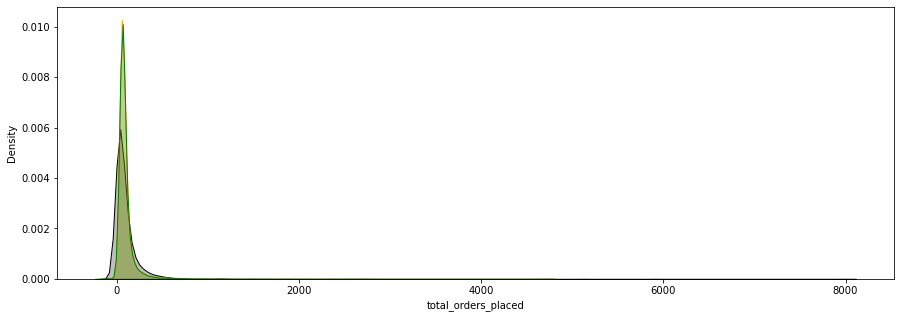

In [56]:

# graph baseline, scaled and categorical model
f, ax = plt.subplots(1, figsize=(15, 5))
# first plot 
sns.kdeplot(joined['total_orders_placed'], shade=True, ax=ax,\
            label='actual', color = 'black')
# second plot 
sns.kdeplot(m2_scaled.fittedvalues, shade=True, ax=ax, \
            label='scaled', color= 'orange')
# third plot 
sns.kdeplot(m3_improved.fittedvalues, shade=True, ax=ax,\
            label='with categorical', color='green')

plt.show()


# Model performance

In [57]:
#R^2
r2 = pd.Series({'Baseline Model': metrics.r2_score(joined['total_orders_placed'],
                                              m1_baseline.fittedvalues),
                'Latest Model': metrics.r2_score(scaled_for_reg['total_orders_placed'],
                                              m3_improved.fittedvalues)})
r2

Baseline Model    0.432001
Latest Model      0.435042
dtype: float64

In [58]:
# MSE
mse = pd.Series({'Baseline Model': metrics.mean_squared_error(joined['total_orders_placed'],
                                                        m1_baseline.fittedvalues),
                 'Latest Model': metrics.mean_squared_error(scaled_for_reg['total_orders_placed'],
                                                         m3_improved.fittedvalues)})

In [59]:
# MAE
# taking the MAE between actual values and the values forecasted by the baseline model
mae = pd.Series({'Baseline Model': metrics.mean_absolute_error(joined['total_orders_placed'],
                                                         m1_baseline.fittedvalues),
                 #taking the MAE between actual values and the values forecasted by m3 model
                 'Latest Model': metrics.mean_absolute_error(scaled_for_reg['total_orders_placed'],
                                                          m3_improved.fittedvalues)})

In [60]:
perf = pd.DataFrame({'MAE': mae,
                     'MSE': mse,
                     'R^2': r2})
perf

,MAE,MSE,R^2
Baseline Model,67.986127,30950.149493,0.432001
Latest Model,68.639493,30784.473586,0.435042


# Cross-Validation
##Split the Data into Train and Test set


In [61]:
##Split the Data into Train and Test set
# Split dataset into train (80%) and test set (20%)
# names of predictive variables
cols = ['total_cancelled_orders', 'average_price_of_items',\
            'total_quantity'] 

# create test and train sets 
x_train, x_test, y_train, y_test =\
                    model_selection.train_test_split(scaled_for_reg[cols], 
                                                    joined['total_orders_placed'],
                                                    test_size=0.8)

# Train Model on Train Set


In [62]:
# Train data on train set
# f is a variable that includes the regression equation
f = 'total_orders_placed ~ total_cancelled_orders + average_price_of_items + total_quantity'

# this is the regression model
m1_train = sm.ols(f, x_train.assign(total_orders_placed=y_train)).fit()

# Compare Parameters and R Squared


In [63]:
# create data frame containin the parameters of full set and of train set
pd.DataFrame({'Full Dataset': m1_baseline.params,
              'Train Set': m1_train.params})

,Full Dataset,Train Set
Intercept,46.741357,91.066402
total_cancelled_orders,16.179230,66.618964
average_price_of_items,-0.014152,-56.268579
total_quantity,0.012865,83.122522


In [64]:
# explore r quared of full data set and of train set 
pd.Series({'Full Dataset': m1_baseline.rsquared,
           'Train Set': m1_train.rsquared})

Full Dataset    0.432001
Train Set       0.510647
dtype: float64

# Predict Test Set Values and Explore R Squared


In [65]:
# make predictions on test set. 
test_prediction = m1_train.params['Intercept'] + \
            x_test.dot(m1_train.params.drop('Intercept'))

#create a series with the r squared of baseline, train set data and test set data
pd.Series({'0-Full Dataset': m1_baseline.rsquared,
           '1-Train Set': m1_train.rsquared,
           '2-Test Set': metrics.r2_score(y_test,
                                        test_prediction)})

0-Full Dataset    0.432001
1-Train Set       0.510647
2-Test Set        0.316475
dtype: float64

# Improve the model: Random forest

In [66]:
# run random forest regression. we can fit and predict in the same line
m4_RandomF = RandomForestRegressor().fit(joined[cols], joined['total_orders_placed'])\
                            .predict(joined[cols])

# Assess Performance


In [67]:
# examine MAE MSE and R suqared of FR 
rf = pd.Series({'R^2': metrics.r2_score(joined['total_orders_placed'], m4_RandomF), 
                'MSE': metrics.mean_squared_error(joined['total_orders_placed'], m4_RandomF),
                'MAE': metrics.mean_absolute_error(joined['total_orders_placed'], m4_RandomF)})

# add RF performance indicators to the table of baseline and m3 model
pd.concat([perf, 
           pd.DataFrame({'Random Forest': rf}).T])

,MAE,MSE,R^2
Baseline Model,67.986127,30950.149493,0.432001
Latest Model,68.639493,30784.473586,0.435042
Random Forest,20.661268,3989.315289,0.926788


# Random Forest Cross Validated

In [68]:
# previously the model was fitted on the same dataset where the predictions were made.
# in this case, we are making the predictions on the text set

# random forest cross validation. 
m4_cv = RandomForestRegressor().fit(x_train, y_train).predict(x_test)

In [69]:
# get MSE, MAE e R2 for cross validated RF
rf_cv = pd.Series({'R^2': metrics.r2_score(y_test, m4_cv), 
                'MSE': metrics.mean_squared_error(y_test, m4_cv),
                'MAE': metrics.mean_absolute_error(y_test, m4_cv)})
pd.concat([perf, 
           pd.DataFrame({'RF': rf}).T,
           pd.DataFrame({'RF-CV': rf_cv}).T])

,MAE,MSE,R^2
Baseline Model,67.986127,30950.149493,0.432001
Latest Model,68.639493,30784.473586,0.435042
RF,20.661268,3989.315289,0.926788
RF-CV,55.244899,43414.937844,0.296683
